# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, local_earthquake_quicklook, data_wrangler, haversine
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance
from obspy.taup import TauPyModel
import math

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [ ]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime(2023,1,7,0,0),
                minmagnitude=4.5,
                maxmagnitude=5.5,
                maxradiuskm=3000, 
                latitude=47.60,
                longitude=-122.33)

print("Returned %s events" % len(events))
 
 

# Choose an event to analyze

In [ ]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df



#event_df.iloc[0::]

# Loading data

In [17]:
df0=pd.read_csv('Catalogo600km3to5mw.csv')
df0
df=pd.read_csv('Catalog-Whidbey-27to3.csv')  
#df
dff1=pd.read_csv('Catalogwhidbey24to27.csv')
dff1
dff2=pd.read_csv('whidbeyhiguestamplitudin1000.csv')
dff3=pd.read_csv('Catalogwhidbey24to27.csv')
dff3
dff4=pd.read_csv('Catalogwhidbey239to20.csv')
dff4
dff5=pd.read_csv('Catalogwhidbey199to17.csv')
dff6=pd.read_csv('Catalogwhidbey169to14.csv')
dff7=pd.read_csv('Catalogwhidbeyglobal67plus.csv')
dff8=pd.read_csv('Catalogwhidbey50to6692500km.csv')
dff9=pd.read_csv('Catalogwhidbey45to55in3000km.csv')
dff10 = pd.read_csv('Catalogwhidbey57toinfin8000km.csv')
#dff11 = pd.read_csv('Catalogwhidbey449to41in3000km.csv')
dff11 = pd.read_csv('Catalogwhidbey449to35in3000km2.csv')
dff11clip = pd.read_csv('Catalogwhidbeyclipped.csv')


# Concat dataframes

In [ ]:
#test2 = pd.read_csv('Catalogwhidbey24to27.csv')
#test2
#test2[test  0] = np.NAN
##test2.fillna(1)
#test2
#test2.clipped = test2.clipped.fillna()
#clipped_data = test2[test2.clipped == 'False']
#clipped_data


In [18]:
testconcat =  pd.concat([df0,df,dff1,dff2,dff3,dff4,dff5,dff6,dff7,dff8,dff9,dff10, dff11], ignore_index = True)
testconcat.shape

(894, 8)

In [ ]:
testconcat.head()

In [19]:
cleandata = testconcat[testconcat.duplicated()]
cleandata

,Magnitud,id_event,Location,detect_seismO,detect_das,clipped,channels,Clipped
147,us7000j2i4,663.747575,NaN,FALSE,False,False,NaN,NaN
148,uw61901446,599.322622,NaN,FALSE,False,NaN,NaN,NaN
149,us7000j1bq,660.020369,NaN,FALSE,False,NaN,NaN,NaN
150,uw61900991,638.24433,NaN,FALSE,False,NaN,NaN,NaN
151,uw61900911,142.027209,NaN,FALSE,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
232,us7000h09u,651.632373,NaN,FALSE,False,NaN,NaN,NaN
233,uw61819402,152.093027,NaN,TRUE,False,NaN,NaN,NaN
234,us6000h6x9,687.908457,NaN,FALSE,False,NaN,NaN,NaN
235,us6000h5x8,662.757444,NaN,norecord,False,NaN,NaN,NaN


# dropping duplicates

In [20]:
cleandata_2 = testconcat.drop_duplicates()

cleandata_2

,Magnitud,id_event,Location,detect_seismO,detect_das,clipped,channels,Clipped
0,3.9,us7000j3g5,496.372832,True,FALSE,False,NaN,NaN
1,3.8,us7000j3f8,495.275940,True,FALSE,False,NaN,NaN
2,4.9,us7000ishe,332.678725,False,TRUE,NaN,NaN,NaN
3,4.4,us7000iqsk,583.335379,True,TRUE,True,NaN,NaN
4,3.4,us7000imha,602.592266,True,norecord,False,NaN,NaN
...,...,...,...,...,...,...,...,...
889,3.62,ci39985119,1469.434383,NaN,FALSE,NaN,NaN,NaN
890,3.54,nc73713331,740.457053,NaN,FALSE,NaN,NaN,NaN
891,3.5,nn00836469,1113.016598,NaN,FALSE,NaN,NaN,NaN
892,3.67,nc73710361,947.299139,NaN,FALSE,NaN,NaN,NaN


# Sellect data to plot

In [21]:
sele_rowcleandata = cleandata_2[cleandata_2.detect_das =='TRUE']
nosele_rowcleandata = cleandata_2[cleandata_2.detect_das =='FALSE']
inconclu_data = cleandata_2[cleandata_2.detect_das == 'INCONCLUSIVE']


In [ ]:
#sanity check
#nosele_rowcleandata
#inconclu_data
#clipped_data
#inconclu_data
cleandata_2.clipped


# Plotting data selected

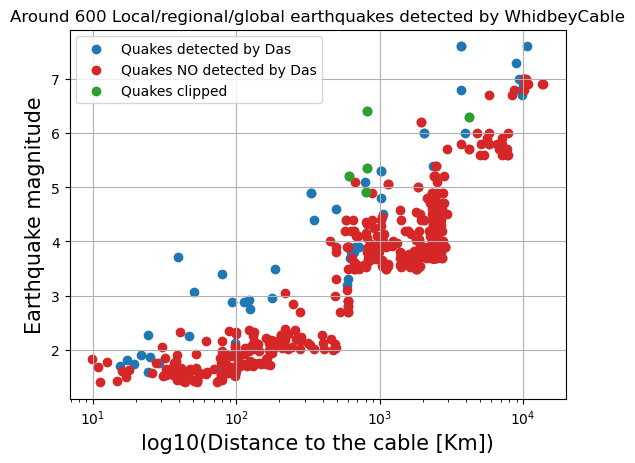

In [22]:
ax=plt.plot(figsize=(25,25))
a=0.5
ax=plt.scatter(sele_rowcleandata.Location, sele_rowcleandata.Magnitud,c='C0', s=None, marker='o',label='Quakes detected by Das')
ax=plt.scatter(nosele_rowcleandata.Location, nosele_rowcleandata.Magnitud,c='C3', s=None, marker='o',label='Quakes NO detected by Das')
#ax=plt.scatter(inconclu_data.Location, inconclu_data.Magnitud,c='C11', s=None, marker='o', label='Inconclusive Quakes')
ax=plt.scatter(dff11clip.Location, dff11clip.Magnitud,c='C2', s=None, marker='o',label='Quakes clipped')
ax=plt.xscale('log')
ax=plt.ylabel('Earthquake magnitude', fontsize=15);
ax=plt.xlabel('log10(Distance to the cable [Km])',fontsize=15)
ax=plt.grid()
ax=plt.title('Around 600 Local/regional/global earthquakes detected by WhidbeyCable')
ax =plt.savefig("whidbeylocalquakesmw-all")
ax = plt.legend()
ax = plt.show()
ax = plt.close()

In [ ]:
#selected_rows0 = df0[df0.detect_das == 'TRUE']
#noselected_rows0 = df0[df0.detect_das == 'FALSE']
#selected_rows1 = dff1[dff1.detect_das == 'TRUE']
#noselected_rows1 = dff1[dff1.detect_das == 'FALSE']
#selected_rows = df[df.detect_das == 'TRUE']
#noselected_rows = df[df.detect_das == 'FALSE']
#selected_rows2 = dff2[dff2.detect_das == 'TRUE']
#noselected_rows2 = dff2[dff2.detect_das == 'FALSE']
#selected_rows3 = dff3[dff3.detect_das == 'TRUE']
#noselected_rows3 = dff3[dff3.detect_das == 'FALSE']
#selected_rows4 = dff4[dff4.detect_das == 'TRUE']
#noselected_rows4 = dff4[dff4.detect_das == 'FALSE']
#selected_rows5 = dff5[dff5.detect_das == 'TRUE']
#noselected_rows5 = dff5[dff5.detect_das == 'FALSE']
#selected_rows6 = dff6[dff6.detect_das == 'TRUE']
#noselected_rows6 = dff6[dff6.detect_das == 'FALSE']
#selected_rows7 = dff7[dff7.detect_das == 'TRUE']
#noselected_rows7 = dff7[dff7.detect_das == 'FALSE']
#plt.scatter(np.log10(selected_rows.Location),selected_rows.Magnitud,s=None, marker='o', alpha=0.9, label='Different earthquakes')
#plt.xlabel('log10(Distance to the cable(Km))')
#plt.ylabel('Magnitud')
#plt.title('Whidbey detection (magnitudes between 2.7 to 2.99 mw)')
#plt.grid()
#plt.savefig("whidbeylocalquakes-lowmagnitud")
#plt.show()
#plt.close()

In [ ]:
#plot testing
#creating plot distance vs magnitud
#plt.subplots(figsize=(10,5))
#plt.scatter(np.log10(dist_kmarray), magnituddarray,s=None, marker='o', alpha=0.9, label='Different earthquakes')
#plt.xlabel('Distance to the cable [Km]')
#plt.ylabel('Earthquakes magnitud');
#plt.legend()
#plt.grid()
#plt.show()

# Data frame for earthquakes with WhibdeyCable